In [26]:
from minimol import Minimol

import os
import math

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.optim.lr_scheduler import LambdaLR
from torch.utils.data import DataLoader, Dataset

from tdc.benchmark_group import admet_group

from contextlib import redirect_stdout, redirect_stderr


group = admet_group(path='admet_data/')


class MultiTaskModel(nn.Module):
    def __init__(self, hidden_dim=512, input_dim=512, head_hidden_dim=256, dropout=0.1, task_names=None):
        super(MultiTaskModel, self).__init__()
        
        self.dense1 = nn.Linear(input_dim, hidden_dim)
        self.dense2 = nn.Linear(hidden_dim, hidden_dim)
        self.dense3 = nn.Linear(hidden_dim, hidden_dim)
        self.bn1 = nn.BatchNorm1d(hidden_dim)
        self.bn2 = nn.BatchNorm1d(hidden_dim)
        self.bn3 = nn.BatchNorm1d(hidden_dim)
        self.dropout = nn.Dropout(dropout)

        self.heads = nn.ModuleDict({
            task_name: nn.Sequential(
                nn.Linear(hidden_dim + input_dim, head_hidden_dim),
                nn.ReLU(),
                nn.Dropout(dropout),
                nn.Linear(head_hidden_dim, 1)
            ) for task_name in task_names
        })

        self.trunk_frozen = False

    def forward(self, x, task_name):
        original_x = x

        x = self.dense1(x)
        x = self.bn1(x)
        x = self.dropout(x)
        x = F.relu(x)

        x = self.dense2(x)
        x = self.bn2(x)
        x = self.dropout(x)
        x = F.relu(x)

        x = self.dense3(x)
        x = self.bn3(x)
        x = self.dropout(x)
        x = F.relu(x)

        x = self.heads[task_name](torch.cat([x, original_x], dim=1))
        return x

    def freeze_trunk(self):
        self.trunk_frozen = True
        for param in self.dense1.parameters():
            param.requires_grad = False
        for param in self.dense2.parameters():
            param.requires_grad = False
        for param in self.bn1.parameters():
            param.requires_grad = False
        for param in self.bn2.parameters():
            param.requires_grad = False

    def unfreeze_trunk(self):
        self.trunk_frozen = False
        for param in self.dense1.parameters():
            param.requires_grad = True
        for param in self.dense2.parameters():
            param.requires_grad = True
        for param in self.bn1.parameters():
            param.requires_grad = True
        for param in self.bn2.parameters():
            param.requires_grad = True



def model_factory(task_names, lr=3e-4, epochs=25, warmup=5, weight_decay=1e-4):
    model = MultiTaskModel(task_names=task_names)
    optimiser = optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

    def lr_fn(epoch):
        if epoch < warmup: return epoch / warmup
        else: return (1 + math.cos(math.pi * (epoch - warmup) / (epochs - warmup))) / 2

    lr_scheduler = LambdaLR(optimiser, lr_lambda=lr_fn)
    return model, optimiser, lr_scheduler


def evaluate(predictor, task, eval_type='val'):
    predictor.eval()
    total_loss = 0

    dataloader = task.val_loader if eval_type == 'val' else task.test_loader

    with torch.no_grad():
        for inputs, targets in dataloader:
            logits = predictor(inputs, task_name=task.name).squeeze()
            loss = task.get_loss(logits, targets)
            total_loss += loss.item()

    loss = total_loss / len(dataloader)
    
    return loss


def evaluate_ensemble(predictors, dataloader, task):
    predictions = []
    with torch.no_grad():
        
        for inputs, _ in dataloader:
            ensemble_logits = [predictor(inputs).squeeze() for predictor in predictors]
            averaged_logits = torch.mean(torch.stack(ensemble_logits), dim=0)
            if task == 'classification':
                predictions += torch.sigmoid(averaged_logits)
            else:
                predictions += averaged_logits

    return predictions


def train_one_epoch(predictor, task, optimiser):
    train_loss = 0
        
    for inputs, targets in task.train_loader:
        optimiser.zero_grad()
        logits = predictor(inputs, task_name=task.name).squeeze()
        loss = task.get_loss(logits, targets)
        loss.backward()
        optimiser.step()
        train_loss += loss.item()

    return predictor, train_loss / len(task.train_loader)


class AdmetDataset(Dataset):
    def __init__(self, samples):
        self.samples = samples['Embedding'].tolist()
        self.targets = [float(target) for target in samples['Y'].tolist()]

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        sample = torch.tensor(self.samples[idx])
        target = torch.tensor(self.targets[idx])
        return sample, target


class Task:
    def __init__(self, dataset_name, featuriser):
        benchmark = group.get(dataset_name)
        with open(os.devnull, 'w') as fnull, redirect_stdout(fnull), redirect_stderr(fnull): # suppress output
            mols_test               = benchmark['test']
            mols_train, mols_valid  = group.get_train_valid_split(benchmark=dataset_name, seed=42)
            mols_test['Embedding']  = featuriser(list(mols_test['Drug']))
            mols_train['Embedding'] = featuriser(list(mols_train['Drug']))
            mols_valid['Embedding'] = featuriser(list(mols_valid['Drug']))
        self.name         = dataset_name
        self.test_loader  = DataLoader(AdmetDataset(mols_test), batch_size=128, shuffle=False)
        self.val_loader   = DataLoader(AdmetDataset(mols_valid), batch_size=128, shuffle=False)
        self.train_loader = DataLoader(AdmetDataset(mols_train), batch_size=32, shuffle=True)
        self.task         = 'classification' if len(benchmark['test']['Y'].unique()) == 2 else 'regression'
        self.loss_fn      = nn.BCELoss() if self.task == 'classification' else nn.MSELoss()        

    def get_loss(self, logits, targets):
        if self.task == 'classification':
            return self.loss_fn(torch.sigmoid(logits), targets)
        else:
            return self.loss_fn(logits, targets)

Found local copy...


In [2]:
featuriser = Minimol()
tasks = {}

print('featurising datasets')
for dataset_i, dataset_name in enumerate(group.dataset_names):
    print(f'dataset={dataset_i + 1} / {len(group.dataset_names)}')
    tasks[dataset_name] = Task(dataset_name, featuriser) 

del featuriser

Found local copy...


featurising datasets
dataset=1 / 22
dataset=2 / 22
dataset=3 / 22
dataset=4 / 22
dataset=5 / 22
dataset=6 / 22


[13:58:25] WARNING: not removing hydrogen atom without neighbors
[13:58:25] WARNING: not removing hydrogen atom without neighbors
[13:58:25] WARNING: not removing hydrogen atom without neighbors
[13:58:25] WARNING: not removing hydrogen atom without neighbors
[13:58:25] WARNING: not removing hydrogen atom without neighbors
[13:58:25] WARNING: not removing hydrogen atom without neighbors
[13:58:26] [13:58:26] WARNING: not removing hydrogen atom without neighbors
[13:58:26] WARNING: not removing hydrogen atom without neighbors
[13:58:26] WARNING: not removing hydrogen atom without neighbors
[13:58:26] WARNING: not removing hydrogen atom without neighbors
[13:58:26] WARNING: not removing hydrogen atom without neighbors
[13:58:26] WARNING: not removing hydrogen atom without neighbors
[13:58:26] WARNING: not removing hydrogen atom without neighbors
[13:58:26] WARNING: not removing hydrogen atom without neighbors
[13:58:26] WARNING: not removing hydrogen atom without neighbors
[13:58:26] WAR

dataset=7 / 22


[13:58:51] [13:58:51] WARNING: not removing hydrogen atom without neighborsWARNING: not removing hydrogen atom without neighbors

[13:58:51] WARNING: not removing hydrogen atom without neighbors
[13:58:51] WARNING: not removing hydrogen atom without neighbors
[13:58:51] WARNING: not removing hydrogen atom without neighbors
[13:58:51] WARNING: not removing hydrogen atom without neighbors
[13:58:51] WARNING: not removing hydrogen atom without neighbors
[13:58:51] WARNING: not removing hydrogen atom without neighbors
[13:58:51] WARNING: not removing hydrogen atom without neighbors
[13:58:51] WARNING: not removing hydrogen atom without neighbors
[13:58:51] WARNING: not removing hydrogen atom without neighbors
[13:58:51] WARNING: not removing hydrogen atom without neighbors
[13:58:51] WARNING: not removing hydrogen atom without neighbors
[13:58:51] WARNING: not removing hydrogen atom without neighbors
[13:58:51] WARNING: not removing hydrogen atom without neighbors
[13:58:51] WARNING: not r

dataset=8 / 22
dataset=9 / 22
dataset=10 / 22
dataset=11 / 22
dataset=12 / 22
dataset=13 / 22
dataset=14 / 22
dataset=15 / 22
dataset=16 / 22
dataset=17 / 22
dataset=18 / 22
dataset=19 / 22


[14:01:27] WARNING: not removing hydrogen atom without neighbors
[14:01:27] WARNING: not removing hydrogen atom without neighbors
[14:01:27] WARNING: not removing hydrogen atom without neighbors
[14:01:27] WARNING: not removing hydrogen atom without neighbors
[14:01:27] WARNING: not removing hydrogen atom without neighbors
[14:01:27] WARNING: not removing hydrogen atom without neighbors


dataset=20 / 22
dataset=21 / 22
dataset=22 / 22


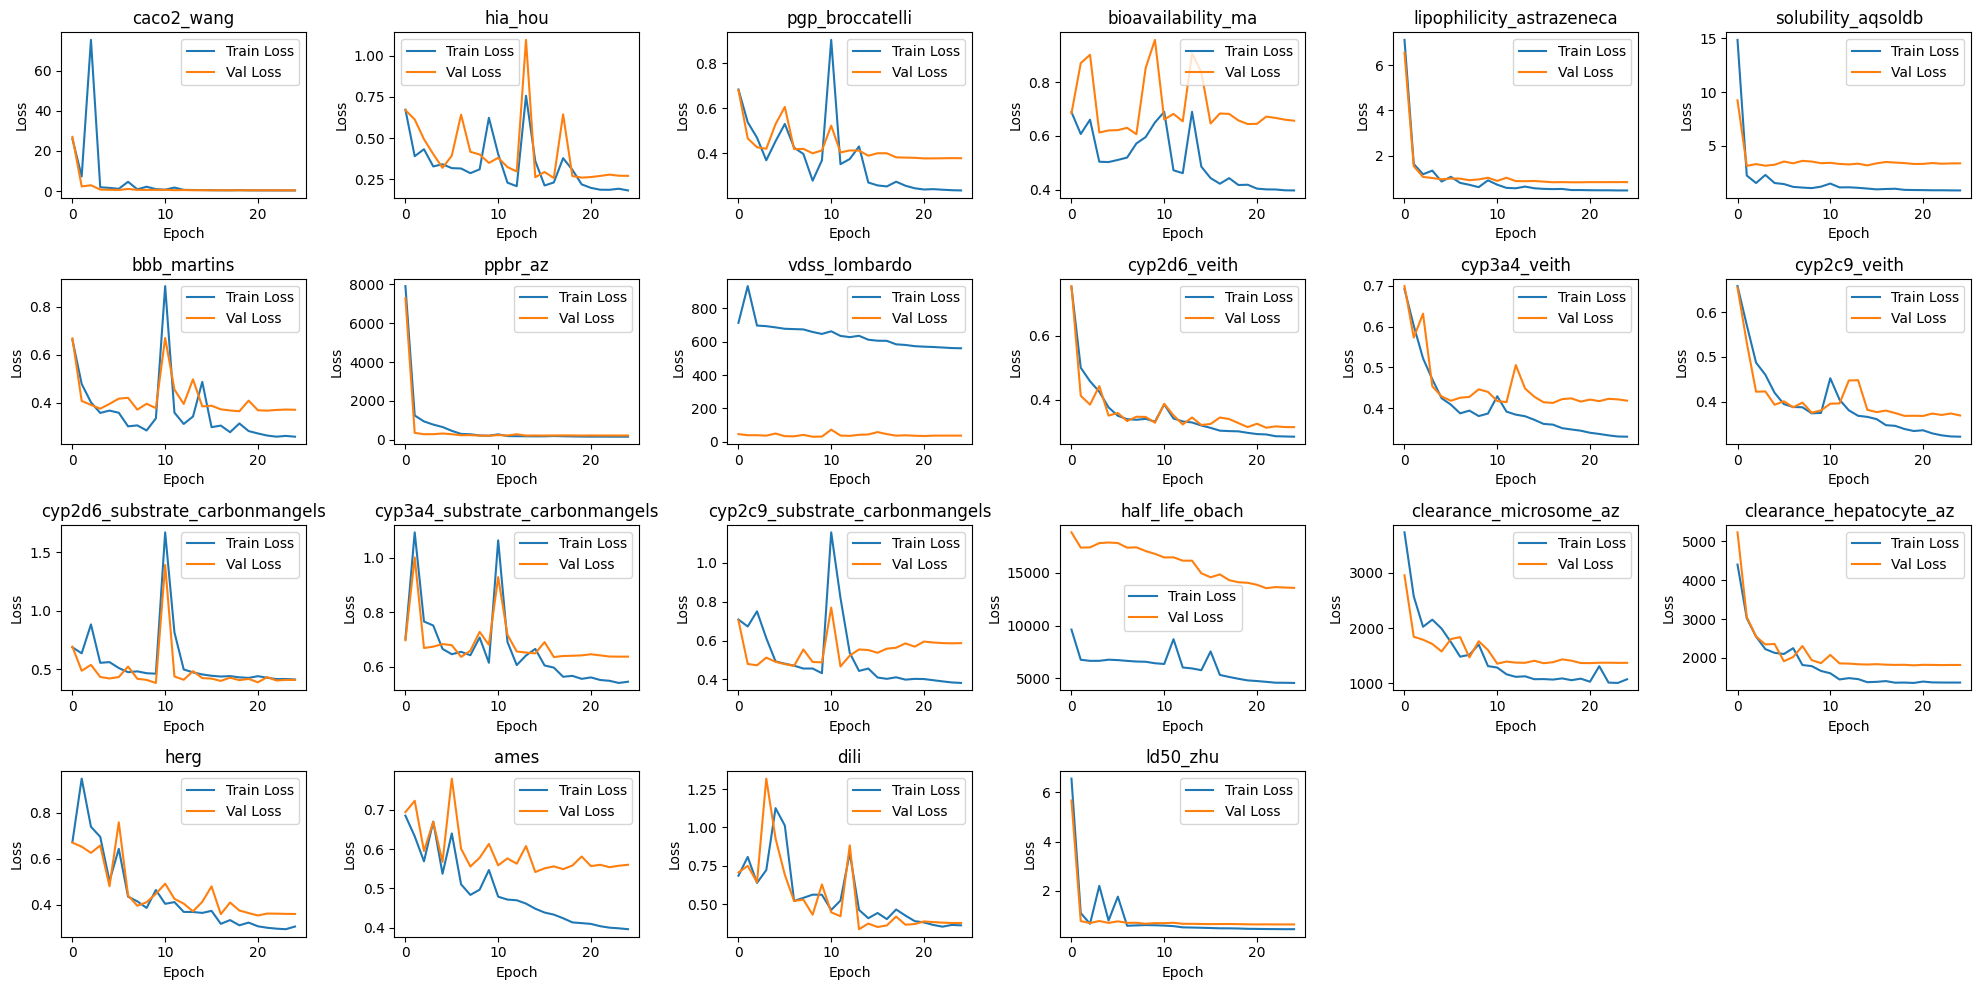

In [27]:
import matplotlib.pyplot as plt
from IPython.display import clear_output, display


SHARED_EPOCHS = 10
SOLO_EPOCHS = 15


train_losses = {task_name: [] for task_name in tasks.keys()}
val_losses = {task_name: [] for task_name in tasks.keys()}


model, optimiser, lr_scheduler = model_factory(
    task_names=tasks.keys(),
    epochs=SOLO_EPOCHS+SHARED_EPOCHS
)

print('beginning shared weights training')
model.unfreeze_trunk()
for epoch in range(SHARED_EPOCHS):
    lr_scheduler.step(epoch)
    for task_i, (task_name, task) in enumerate(tasks.items()):
        model, train_loss = train_one_epoch(model, task, optimiser)
        val_loss = evaluate(model, task, eval_type='val')
        
        train_losses[task_name].append(train_loss)
        val_losses[task_name].append(val_loss)

    clear_output(wait=True)
    plt.figure(figsize=(20, 10))

    for i, (task_name, _) in enumerate(tasks.items()):
        plt.subplot(4, 6, i+1)  # Assuming 22 tasks, this creates a 4x6 grid
        plt.plot(train_losses[task_name], label='Train Loss')
        plt.plot(val_losses[task_name], label='Val Loss')
        plt.title(task_name)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

    plt.tight_layout()
    display(plt.gcf())
    plt.close()


print('beginning solo-task post-training')
model.freeze_trunk()
for epoch in range(SOLO_EPOCHS):
    lr_scheduler.step(SHARED_EPOCHS + epoch)
    for task_i, (task_name, task) in enumerate(tasks.items()):
        model, train_loss = train_one_epoch(model, task, optimiser)
        val_loss = evaluate(model, task, eval_type='val')
        
        train_losses[task_name].append(train_loss)
        val_losses[task_name].append(val_loss)

    clear_output(wait=True)
    plt.figure(figsize=(20, 10))

    for i, (task_name, _) in enumerate(tasks.items()):
        plt.subplot(4, 6, i+1)
        plt.plot(train_losses[task_name], label='Train Loss')
        plt.plot(val_losses[task_name], label='Val Loss')
        plt.title(task_name)
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

    plt.tight_layout()
    display(plt.gcf())
    plt.close()

In [29]:
predictions = {}
for task_i, (task_name, task) in enumerate(tasks.items()):

    with torch.no_grad():
        y_pred_test = []
        for inputs, _ in task.test_loader:
            logits = model(inputs, task_name=task_name).squeeze()
            if task.task == 'classification':
                y_pred_test += torch.sigmoid(logits)
            else:
                y_pred_test += logits

    predictions[task_name] = y_pred_test

predictions_list = [predictions] * 5
results = group.evaluate_many(predictions_list)
print(results)


{
    'caco2_wang': [0.35, 0.018],
    'hia_hou': [0.993, 0.005],
    'pgp_broccatelli': [0.942, 0.002],
    'bioavailability_ma': [0.689, 0.02],
    'lipophilicity_astrazeneca': [0.456, 0.008],
    'solubility_aqsoldb': [0.741, 0.013],
    'bbb_martins': [0.924, 0.003],
    'ppbr_az': [7.696, 0.125],
    'vdss_lombardo': [0.535, 0.027],
    'cyp2d6_veith': [0.719, 0.004],
    'cyp3a4_veith': [0.877, 0.001],
    'cyp2c9_veith': [0.823, 0.006],
    'cyp2d6_substrate_carbonmangels': [0.695, 0.032],
    'cyp3a4_substrate_carbonmangels': [0.663, 0.008],
    'cyp2c9_substrate_carbonmangels': [0.474, 0.025],
    'half_life_obach': [0.495, 0.042],
    'clearance_microsome_az': [0.628, 0.005],
    'clearance_hepatocyte_az': [0.446, 0.029],
    'herg': [0.846, 0.016],
    'ames': [0.849, 0.004],
    'dili': [0.956, 0.006],
    'ld50_zhu': [0.585, 0.008]
}

{'caco2_wang': [0.668, 0.0], 'hia_hou': [0.969, 0.0], 'pgp_broccatelli': [0.936, 0.0], 'bioavailability_ma': [0.648, 0.0], 'lipophilicity_astrazeneca': [0.562, 0.0], 'solubility_aqsoldb': [0.821, 0.0], 'bbb_martins': [0.92, 0.0], 'ppbr_az': [9.884, 0.0], 'vdss_lombardo': [0.421, 0.0], 'cyp2d6_veith': [0.69, 0.0], 'cyp3a4_veith': [0.858, 0.0], 'cyp2c9_veith': [0.808, 0.0], 'cyp2d6_substrate_carbonmangels': [0.654, 0.0], 'cyp3a4_substrate_carbonmangels': [0.629, 0.0], 'cyp2c9_substrate_carbonmangels': [0.471, 0.0], 'half_life_obach': [0.374, 0.0], 'clearance_microsome_az': [0.618, 0.0], 'clearance_hepatocyte_az': [0.438, 0.0], 'herg': [0.825, 0.0], 'ames': [0.833, 0.0], 'dili': [0.956, 0.0], 'ld50_zhu': [0.704, 0.0]}


{'caco2_wang': [0.35, 0.018],
 'hia_hou': [0.993, 0.005],
 'pgp_broccatelli': [0.942, 0.002],
 'bioavailability_ma': [0.689, 0.02],
 'lipophilicity_astrazeneca': [0.456, 0.008],
 'solubility_aqsoldb': [0.741, 0.013],
 'bbb_martins': [0.924, 0.003],
 'ppbr_az': [7.696, 0.125],
 'vdss_lombardo': [0.535, 0.027],
 'cyp2d6_veith': [0.719, 0.004],
 'cyp3a4_veith': [0.877, 0.001],
 'cyp2c9_veith': [0.823, 0.006],
 'cyp2d6_substrate_carbonmangels': [0.695, 0.032],
 'cyp3a4_substrate_carbonmangels': [0.663, 0.008],
 'cyp2c9_substrate_carbonmangels': [0.474, 0.025],
 'half_life_obach': [0.495, 0.042],
 'clearance_microsome_az': [0.628, 0.005],
 'clearance_hepatocyte_az': [0.446, 0.029],
 'herg': [0.846, 0.016],
 'ames': [0.849, 0.004],
 'dili': [0.956, 0.006],
 'ld50_zhu': [0.585, 0.008]}